<a href="https://colab.research.google.com/github/jamesmaddison/DisasterTweets/blob/main/Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Disaster Tweets

This is my attempt at the Kaggle Disaster Tweets competition. 
This notebook currently achieves an accuracy of 0.79589 on the kaggle of test set.
The notbook consists of:

*   Data Cleaning
*   An LSTM Model containing GloVe initiated embeddings, an LSTM and two fully connected layers.
*   Training and Analysis
*   Submission creation




In [ ]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import torch
import os

from tqdm.notebook import tqdm

from torch.utils.data import DataLoader
import torch
from torch.nn import functional as F
from torch.autograd import Variable


from torchtext.legacy import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe



import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torch.nn.functional as f
import torch
import torch.nn as nn

from torchtext.vocab import Vectors, GloVe



import math
%matplotlib inline

nltk.download('punkt')
nltk.download('stopwords')

import torch.optim as optim

Import datasets

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
train_Y = df_train["target"]
train_raw_tweets = df_train["text"]

df_train.drop(['keyword', 'location'], axis=1, inplace=True)
df_test.drop(['keyword', 'location'], axis=1, inplace=True)


In [ ]:
df_test.head(10)

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan
5,12,We're shaking...It's an earthquake
6,21,They'd probably still show more life than Arse...
7,22,Hey! How are you?
8,27,What a nice hat?
9,29,Fuck off!


# Clean/Prep Data


*   Move to lower case
*   Remove punctuation
*   Standardise Hashtags
*   Remove URLs
*   Place cleaned data in CSV for import to torch datasets



In [ ]:
df_train["text"] = df_train["text"].apply(lambda x : str.lower(x))
df_test["text"] = df_test["text"].apply(lambda x : str.lower(x))

In [ ]:
def cleanText(text):
  #Remove @ mentions, replace with nothing
  text = re.sub(r'@[A-Za-z0-9]+', '', text, flags=re.MULTILINE)

  #Remove # symbol from hash tags to assist with tokenisation
  text = re.sub(r'#', '', text, flags=re.MULTILINE)

  #Remove @ mentions, replace with nothing
  text = re.sub(r'https?:\/\/\S*', '', text, flags=re.MULTILINE)

  punctuations = '@#!?+&*[]-_%.:,/();$=><|{}^' + "'`"
  for p in punctuations:
    text = text.replace(p, '')

  text = text.lstrip()

  return text

In [ ]:
print('Before Clearning: \n')
print(train_raw_tweets[97])
print(train_raw_tweets[99])
print(train_raw_tweets[31])

print('\n\nAfter Clearning: \n')

print(cleanText(train_raw_tweets[97]))
print(cleanText(train_raw_tweets[98]))
print(cleanText(train_raw_tweets[31]))

Before Clearning: 

#BREAKING: there was a deadly motorcycle car accident that happened to #Hagerstown today. I'll have more details at 5 @Your4State. #WHAG
only had a car for not even a week and got in a fucking car accident .. Mfs can't fucking drive .
@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C


After Clearning: 

BREAKING there was a deadly motorcycle car accident that happened to Hagerstown today Ill have more details at 5  WHAG
were you marinading it or was it an accident
Wholesale Markets ablaze 


In [ ]:
df_train["text"] = df_train["text"].apply(cleanText)
df_test["text"] = df_test["text"].apply(cleanText)
train_raw_tweets = df_train["text"]

In [ ]:
df_test.head(10)

,id,text
0,0,just happened a terrible car crash
1,2,heard about earthquake is different cities sta...
2,3,there is a forest fire at spot pond geese are ...
3,9,apocalypse lighting spokane wildfires
4,11,typhoon soudelor kills 28 in china and taiwan
5,12,were shakingits an earthquake
6,21,theyd probably still show more life than arsen...
7,22,hey how are you
8,27,what a nice hat
9,29,fuck off


In [ ]:
train_raw_tweets.head(20)

0     our deeds are the reason of this earthquake ma...
1                 forest fire near la ronge sask canada
2     all residents asked to shelter in place are be...
3     13000 people receive wildfires evacuation orde...
4     just got sent this photo from ruby alaska as s...
5     rockyfire update  california hwy 20 closed in ...
6     flood disaster heavy rain causes flash floodin...
7     im on top of the hill and i can see a fire in ...
8     theres an emergency evacuation happening now i...
9      im afraid that the tornado is coming to our area
10          three people died from the heat wave so far
11    haha south tampa is getting flooded hah wait a...
12    raining flooding florida tampabay tampa 18 or ...
13                flood in bago myanmar we arrived bago
14    damage to school bus on 80 in multi car crash ...
15                                         whats up man
16                                        i love fruits
17                                     summer is

In [ ]:
def prepare_csv(df_train, df_test, seed=27, val_ratio=0.3):
    idx = np.arange(df_train.shape[0])
    
    np.random.seed(seed)
    np.random.shuffle(idx)
    
    val_size = int(len(idx) * val_ratio)
    
    if not os.path.exists('cache'):
        os.makedirs('cache')
    
    df_train.iloc[idx[val_size:], :][['id', 'target', 'text']].to_csv(
        'cache/dataset_train.csv', index=False
    )
    
    df_train.iloc[idx[:val_size], :][['id', 'target', 'text']].to_csv(
        'cache/dataset_val.csv', index=False
    )

    df_train[['id', 'target', 'text']].to_csv('cache/dataset_full.csv', index=False)
    
    df_test[['id', 'text']].to_csv('cache/dataset_test.csv',
                   index=False)

# Define Model Data
* Define torchtext datasets against the pre-trained GloVe word vectors (Add UNK and PAD tags) and tokenize as word IDs 
* Create torch data iterators containing training, validation and test sets


In [ ]:
def get_iterator(dataset, batch_size, train=True,
                 shuffle=True, repeat=False):
    
    device = torch.device('cuda:0' if torch.cuda.is_available()
                          else 'cpu')
    
    dataset_iter = data.Iterator(
        dataset, batch_size=batch_size, device=device,
        train=train, shuffle=shuffle, repeat=repeat,
        sort=False
    )
    
    return dataset_iter

In [ ]:
import logging
from copy import deepcopy

LOGGER = logging.getLogger('tweets_dataset')

def get_dataset(fix_length=100, lower=False, vectors=None):
    
    if vectors is not None:
        lower=True
        
    LOGGER.debug('Preparing CSV files...')
    prepare_csv(train, test)

    
    
    TEXT = data.Field(sequential=True, 
#                       tokenize='spacy', 
                      lower=True, 
                      include_lengths=True, 
                      batch_first=True, 
                      fix_length=25)
    LABEL = data.Field(use_vocab=False,
                       sequential=False,
                       dtype=torch.float16)
    ID = data.Field(use_vocab=False,
                    sequential=False,
                    dtype=torch.float16)
    
    
    LOGGER.debug('Reading train csv files...')
    
    train_temp, val_temp = data.TabularDataset.splits(
        path='cache/', format='csv', skip_header=True,
        train='dataset_train.csv', validation='dataset_val.csv',
        fields=[
            ('id', ID),
            ('target', LABEL),
            ('text', TEXT)
        ]
    )
    
    LOGGER.debug('Reading test csv file...')
    
    test_temp = data.TabularDataset(
        path='cache/dataset_test.csv', format='csv',
        skip_header=True,
        fields=[
            ('id', ID),
            ('text', TEXT)
        ]
    )

    LOGGER.debug('Reading full csv file...')
    
    full_temp = data.TabularDataset(
        path='cache/dataset_full.csv', format='csv',
        skip_header=True,
        fields=[
            ('id', ID),
            ('target', LABEL),
            ('text', TEXT)
        ]
    )
    
    
    LOGGER.debug('Building vocabulary...')
    
    TEXT.build_vocab(
        train_temp, val_temp, test_temp,
        max_size=20000,
        min_freq=10,
        vectors=GloVe(name='6B', dim=300)  # We use it for getting vocabulary of words
    )
    LABEL.build_vocab(
        train_temp
    )
    ID.build_vocab(
        train_temp, val_temp, test_temp
    )
    
    word_embeddings = TEXT.vocab.vectors
    vocab_size = len(TEXT.vocab)
    
    train_iter = get_iterator(train_temp, batch_size=32, 
                              train=True, shuffle=True,
                              repeat=False)
    val_iter = get_iterator(val_temp, batch_size=32, 
                            train=True, shuffle=True,
                            repeat=False)
    test_iter = get_iterator(test_temp, batch_size=32, 
                             train=False, shuffle=False,
                             repeat=False)
    full_iter = get_iterator(full_temp, batch_size=32, 
                              train=True, shuffle=True,
                              repeat=False)
    
    
    LOGGER.debug('Done preparing the datasets')
    
    return TEXT, vocab_size, word_embeddings, train_iter, val_iter, test_iter, full_iter

In [ ]:
train = df_train
test = df_test

TEXT, vocab_size, word_embeddings, train_iter, val_iter, test_iter, full_iter = get_dataset()

100%|█████████▉| 399999/400000 [00:53<00:00, 7491.92it/s]


# Define LSTM Model

In [ ]:
class LSTMClassifier(torch.nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, weights):
        super(LSTMClassifier, self).__init__()
        
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.word_embeddings = torch.nn.Embedding(vocab_size,
                                                  embedding_dim)
        self.word_embeddings.weight = torch.nn.Parameter(weights,
                                                         requires_grad=False)
        
        self.dropout_1 = torch.nn.Dropout(0.3)
        self.lstm = torch.nn.LSTM(embedding_dim,
                                  hidden_dim,
                                  n_layers,
                                  dropout=0.3,
                                  batch_first=True)
        
        self.dropout_2 = torch.nn.Dropout(0.3)
        self.hidden_layer = torch.nn.Linear(hidden_dim, hidden_dim)

        self.label_layer = torch.nn.Linear(hidden_dim, output_size)
        
        self.relu = torch.nn.ReLU()

        self.act = torch.nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        
        x = self.word_embeddings(x)
        
        x = self.dropout_1(x)
        
        lstm_out, hidden = self.lstm(x, hidden)

        lstm_out = lstm_out[:,-1,:]
                
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout_2(lstm_out)

        out = self.hidden_layer(out)

        out = self.relu(out)

        out = self.label_layer(out)    

        out = out.view(batch_size, -1, self.output_size)
        out = out[:, -1, :]

        out = self.act(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        
        return hidden

#Train Model

In [ ]:
def train_model(model, train_iter, val_iter, optim, loss, num_epochs, batch_size=32):
    h = model.init_hidden(batch_size)
    
    clip = 5
    val_loss_min = np.Inf
    
    total_train_epoch_loss = list()
    total_train_epoch_acc = list()
        
    total_val_epoch_loss = list()
    total_val_epoch_acc = list()
        
    
    device = torch.device('cuda:0' if torch.cuda.is_available()
                           else 'cpu')
    
    for epoch in range(num_epochs):

        model.train()
        
        train_epoch_loss = list()
        train_epoch_acc = list()
        
        val_epoch_loss = list()
        val_epoch_acc = list()
        
        for idx, batch in enumerate(tqdm(train_iter)):
            h = tuple([e.data for e in h])

            text = batch.text[0]
            target = batch.target
            #target = target - 1
            target = target.type(torch.LongTensor)

            text = text.to(device)
            target = target.to(device)

            optim.zero_grad()
            
            if text.size()[0] is not batch_size:
                continue
            
            prediction, h = model(text, h)
                
            loss_train = loss(prediction.squeeze(), target)
            loss_train.backward()

            num_corrects = (torch.max(prediction, 1)[1].
                                view(target.size()).data == target.data).float().sum()

            acc = 100.0 * num_corrects / len(batch)

            train_epoch_loss.append(loss_train.item())
            train_epoch_acc.append(acc.item())
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            
            optim.step()
    
        print(f'Train Epoch: {epoch}, Training Loss: {np.mean(train_epoch_loss):.4f}, Training Accuracy: {np.mean(train_epoch_acc): .2f}%')

        model.eval()

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_iter)):
                val_h = tuple([e.data for e in h])

                text = batch.text[0]
                target = batch.target
                target = target 
                target = target.type(torch.LongTensor)
                
                text = text.to(device)
                target = target.to(device)
                
                if text.size()[0] is not batch_size:
                    continue

                prediction, h = model(text, h)
                loss_val = loss(prediction.squeeze(), target)

                num_corrects = (torch.max(prediction, 1)[1].
                                view(target.size()).data == target.data).float().sum()

                acc = 100.0 * num_corrects / len(batch)

                val_epoch_loss.append(loss_val.item())
                val_epoch_acc.append(acc.item())
                
            print(f'Vadlidation Epoch: {epoch}, Training Loss: {np.mean(val_epoch_loss):.4f}, Training Accuracy: {np.mean(val_epoch_acc): .2f}%')
                
            if np.mean(val_epoch_loss) <= val_loss_min:
#                 torch.save(model.state_dict(), 'state_dict.pth')
                print('Validation loss decreased ({:.6f} --> {:.6f})'.
                      format(val_loss_min, np.mean(val_epoch_loss)))
                
                val_loss_min = np.mean(val_epoch_loss)
                
        total_train_epoch_loss.append(np.mean(train_epoch_loss))
        total_train_epoch_acc.append(np.mean(train_epoch_acc))
    
        total_val_epoch_loss.append(np.mean(val_epoch_loss))
        total_val_epoch_acc.append(np.mean(val_epoch_acc))
    
    return (total_train_epoch_loss, total_train_epoch_acc,
            total_val_epoch_loss, total_val_epoch_acc)
lr = 1e-4
batch_size = 32
output_size = 2
hidden_size = 128
embedding_length = 300

model = LSTMClassifier(vocab_size=vocab_size, 
                       output_size=output_size, 
                       embedding_dim=embedding_length,
                       hidden_dim=hidden_size,
                       n_layers=2,
                       weights=word_embeddings
)

device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')
    
model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)
loss = torch.nn.CrossEntropyLoss()
    
train_loss, train_acc, val_loss, val_acc = train_model(model=model,
                                                       train_iter=train_iter,
                                                       val_iter=val_iter,
                                                       optim=optim,
                                                       loss=loss,
                                                       num_epochs=40,
                                                       batch_size=batch_size)

  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 0, Training Loss: 0.6783, Training Accuracy:  57.64%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 0, Training Loss: 0.6470, Training Accuracy:  55.55%
Validation loss decreased (inf --> 0.646961)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 1, Training Loss: 0.6147, Training Accuracy:  63.01%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 1, Training Loss: 0.6017, Training Accuracy:  74.30%
Validation loss decreased (0.646961 --> 0.601680)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 2, Training Loss: 0.5611, Training Accuracy:  76.73%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 2, Training Loss: 0.5736, Training Accuracy:  72.58%
Validation loss decreased (0.601680 --> 0.573637)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 3, Training Loss: 0.5306, Training Accuracy:  77.90%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 3, Training Loss: 0.5357, Training Accuracy:  77.16%
Validation loss decreased (0.573637 --> 0.535687)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 4, Training Loss: 0.5224, Training Accuracy:  78.29%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 4, Training Loss: 0.5288, Training Accuracy:  77.64%
Validation loss decreased (0.535687 --> 0.528834)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 5, Training Loss: 0.5166, Training Accuracy:  78.90%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 5, Training Loss: 0.5253, Training Accuracy:  78.17%
Validation loss decreased (0.528834 --> 0.525260)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 6, Training Loss: 0.5129, Training Accuracy:  78.97%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 6, Training Loss: 0.5260, Training Accuracy:  78.17%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 7, Training Loss: 0.5098, Training Accuracy:  79.39%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 7, Training Loss: 0.5208, Training Accuracy:  78.08%
Validation loss decreased (0.525260 --> 0.520805)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 8, Training Loss: 0.5034, Training Accuracy:  80.20%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 8, Training Loss: 0.5232, Training Accuracy:  78.17%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 9, Training Loss: 0.5007, Training Accuracy:  80.20%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 9, Training Loss: 0.5230, Training Accuracy:  78.17%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 10, Training Loss: 0.5015, Training Accuracy:  80.16%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 10, Training Loss: 0.5179, Training Accuracy:  78.61%
Validation loss decreased (0.520805 --> 0.517919)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 11, Training Loss: 0.4969, Training Accuracy:  80.74%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 11, Training Loss: 0.5232, Training Accuracy:  78.08%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 12, Training Loss: 0.4939, Training Accuracy:  81.25%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 12, Training Loss: 0.5168, Training Accuracy:  78.43%
Validation loss decreased (0.517919 --> 0.516805)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 13, Training Loss: 0.4924, Training Accuracy:  81.40%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 13, Training Loss: 0.5208, Training Accuracy:  78.61%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 14, Training Loss: 0.4905, Training Accuracy:  81.31%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 14, Training Loss: 0.5160, Training Accuracy:  79.14%
Validation loss decreased (0.516805 --> 0.515972)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 15, Training Loss: 0.4921, Training Accuracy:  81.01%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 15, Training Loss: 0.5153, Training Accuracy:  78.79%
Validation loss decreased (0.515972 --> 0.515303)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 16, Training Loss: 0.4911, Training Accuracy:  81.40%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 16, Training Loss: 0.5167, Training Accuracy:  78.83%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 17, Training Loss: 0.4897, Training Accuracy:  81.59%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 17, Training Loss: 0.5135, Training Accuracy:  79.49%
Validation loss decreased (0.515303 --> 0.513522)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 18, Training Loss: 0.4865, Training Accuracy:  82.12%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 18, Training Loss: 0.5152, Training Accuracy:  78.87%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 19, Training Loss: 0.4865, Training Accuracy:  82.10%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 19, Training Loss: 0.5150, Training Accuracy:  78.83%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 20, Training Loss: 0.4844, Training Accuracy:  82.27%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 20, Training Loss: 0.5239, Training Accuracy:  78.12%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 21, Training Loss: 0.4863, Training Accuracy:  82.19%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 21, Training Loss: 0.5177, Training Accuracy:  78.92%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 22, Training Loss: 0.4819, Training Accuracy:  82.77%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 22, Training Loss: 0.5172, Training Accuracy:  78.52%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 23, Training Loss: 0.4796, Training Accuracy:  82.70%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 23, Training Loss: 0.5103, Training Accuracy:  79.40%
Validation loss decreased (0.513522 --> 0.510280)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 24, Training Loss: 0.4812, Training Accuracy:  82.62%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 24, Training Loss: 0.5183, Training Accuracy:  78.92%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 25, Training Loss: 0.4775, Training Accuracy:  83.40%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 25, Training Loss: 0.5125, Training Accuracy:  79.40%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 26, Training Loss: 0.4769, Training Accuracy:  83.43%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 26, Training Loss: 0.5203, Training Accuracy:  78.48%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 27, Training Loss: 0.4786, Training Accuracy:  82.96%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 27, Training Loss: 0.5133, Training Accuracy:  79.18%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 28, Training Loss: 0.4783, Training Accuracy:  83.08%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 28, Training Loss: 0.5142, Training Accuracy:  79.09%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 29, Training Loss: 0.4796, Training Accuracy:  82.61%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 29, Training Loss: 0.5195, Training Accuracy:  78.74%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 30, Training Loss: 0.4736, Training Accuracy:  83.70%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 30, Training Loss: 0.5149, Training Accuracy:  79.01%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 31, Training Loss: 0.4725, Training Accuracy:  83.98%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 31, Training Loss: 0.5205, Training Accuracy:  78.26%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 32, Training Loss: 0.4710, Training Accuracy:  83.72%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 32, Training Loss: 0.5171, Training Accuracy:  78.79%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 33, Training Loss: 0.4734, Training Accuracy:  83.25%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 33, Training Loss: 0.5182, Training Accuracy:  78.79%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 34, Training Loss: 0.4711, Training Accuracy:  83.85%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 34, Training Loss: 0.5150, Training Accuracy:  79.18%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 35, Training Loss: 0.4689, Training Accuracy:  84.00%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 35, Training Loss: 0.5194, Training Accuracy:  78.96%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 36, Training Loss: 0.4670, Training Accuracy:  84.21%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 36, Training Loss: 0.5157, Training Accuracy:  79.36%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 37, Training Loss: 0.4689, Training Accuracy:  84.05%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 37, Training Loss: 0.5161, Training Accuracy:  79.18%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 38, Training Loss: 0.4653, Training Accuracy:  84.26%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 38, Training Loss: 0.5180, Training Accuracy:  78.48%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 39, Training Loss: 0.4663, Training Accuracy:  84.22%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 39, Training Loss: 0.5173, Training Accuracy:  79.05%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


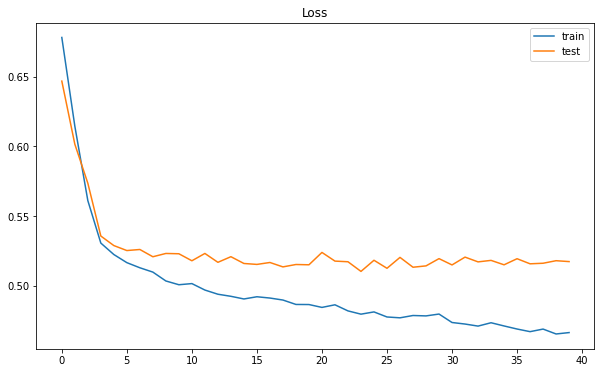

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Loss')
sns.lineplot(range(len(train_loss)), train_loss, label='train')
sns.lineplot(range(len(val_loss)), val_loss, label='test')

#Assess Traning

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


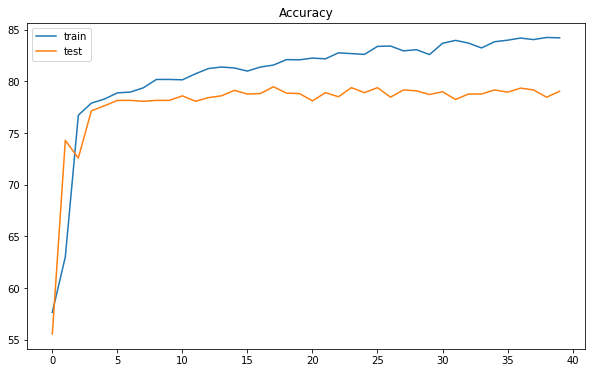

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Accuracy')
sns.lineplot(range(len(train_acc)), train_acc, label='train')
sns.lineplot(range(len(val_acc)), val_acc, label='test')

# Train on entire Train set (no val) befor submission

In [ ]:
def train_model(model, train_iter, optim, loss, num_epochs, batch_size=32):
    h = model.init_hidden(batch_size)
    
    clip = 5

    
    total_train_epoch_loss = list()
    total_train_epoch_acc = list()
        

    
    device = torch.device('cuda:0' if torch.cuda.is_available()
                           else 'cpu')
    
    for epoch in range(num_epochs):

        model.train()
        
        train_epoch_loss = list()
        train_epoch_acc = list()
 
        
        for idx, batch in enumerate(tqdm(full_iter)):
            h = tuple([e.data for e in h])

            text = batch.text[0]
            target = batch.target
            #target = target - 1
            target = target.type(torch.LongTensor)

            text = text.to(device)
            target = target.to(device)

            optim.zero_grad()
            
            if text.size()[0] is not batch_size:
                continue
            
            prediction, h = model(text, h)
                
            loss_train = loss(prediction.squeeze(), target)
            loss_train.backward()

            num_corrects = (torch.max(prediction, 1)[1].
                                view(target.size()).data == target.data).float().sum()

            acc = 100.0 * num_corrects / len(batch)

            train_epoch_loss.append(loss_train.item())
            train_epoch_acc.append(acc.item())
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            
            optim.step()
    
        print(f'Train Epoch: {epoch}, Training Loss: {np.mean(train_epoch_loss):.4f}, Training Accuracy: {np.mean(train_epoch_acc): .2f}%')

        model.eval()

  
                
        total_train_epoch_loss.append(np.mean(train_epoch_loss))
        total_train_epoch_acc.append(np.mean(train_epoch_acc))
    
        
    return (total_train_epoch_loss, total_train_epoch_acc)
lr = 1e-4
batch_size = 32
output_size = 2
hidden_size = 128
embedding_length = 300

model = LSTMClassifier(vocab_size=vocab_size, 
                       output_size=output_size, 
                       embedding_dim=embedding_length,
                       hidden_dim=hidden_size,
                       n_layers=2,
                       weights=word_embeddings
)

device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')
    
model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)
loss = torch.nn.CrossEntropyLoss()
    
train_loss, train_acc = train_model(model=model, train_iter=train_iter,
                                                       optim=optim,
                                                       loss=loss,
                                                       num_epochs=40,
                                                       batch_size=batch_size)

  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 0, Training Loss: 0.6722, Training Accuracy:  57.03%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 1, Training Loss: 0.5874, Training Accuracy:  71.16%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 2, Training Loss: 0.5372, Training Accuracy:  76.79%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 3, Training Loss: 0.5249, Training Accuracy:  77.85%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 4, Training Loss: 0.5177, Training Accuracy:  78.57%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 5, Training Loss: 0.5143, Training Accuracy:  79.02%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 6, Training Loss: 0.5100, Training Accuracy:  79.48%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 7, Training Loss: 0.5100, Training Accuracy:  79.26%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 8, Training Loss: 0.5048, Training Accuracy:  79.98%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 9, Training Loss: 0.5048, Training Accuracy:  80.17%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 10, Training Loss: 0.5025, Training Accuracy:  80.27%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 11, Training Loss: 0.5001, Training Accuracy:  80.55%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 12, Training Loss: 0.4971, Training Accuracy:  80.97%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 13, Training Loss: 0.4960, Training Accuracy:  80.96%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 14, Training Loss: 0.4967, Training Accuracy:  81.03%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 15, Training Loss: 0.4927, Training Accuracy:  81.62%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 16, Training Loss: 0.4952, Training Accuracy:  81.04%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 17, Training Loss: 0.4890, Training Accuracy:  81.84%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 18, Training Loss: 0.4889, Training Accuracy:  81.83%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 19, Training Loss: 0.4916, Training Accuracy:  81.42%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 20, Training Loss: 0.4888, Training Accuracy:  81.82%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 21, Training Loss: 0.4870, Training Accuracy:  81.94%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 22, Training Loss: 0.4862, Training Accuracy:  82.01%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 23, Training Loss: 0.4857, Training Accuracy:  82.25%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 24, Training Loss: 0.4819, Training Accuracy:  82.61%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 25, Training Loss: 0.4818, Training Accuracy:  82.50%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 26, Training Loss: 0.4835, Training Accuracy:  82.48%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 27, Training Loss: 0.4801, Training Accuracy:  82.69%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 28, Training Loss: 0.4789, Training Accuracy:  82.95%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 29, Training Loss: 0.4780, Training Accuracy:  83.04%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 30, Training Loss: 0.4750, Training Accuracy:  83.49%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 31, Training Loss: 0.4752, Training Accuracy:  83.40%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 32, Training Loss: 0.4737, Training Accuracy:  83.37%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 33, Training Loss: 0.4737, Training Accuracy:  83.54%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 34, Training Loss: 0.4755, Training Accuracy:  83.21%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 35, Training Loss: 0.4756, Training Accuracy:  83.29%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 36, Training Loss: 0.4717, Training Accuracy:  83.72%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 37, Training Loss: 0.4711, Training Accuracy:  83.61%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 38, Training Loss: 0.4679, Training Accuracy:  84.20%


  0%|          | 0/238 [00:00<?, ?it/s]

Train Epoch: 39, Training Loss: 0.4691, Training Accuracy:  83.93%


#Create submission file from Test Data

In [ ]:
results = list()

with torch.no_grad():
    for batch in tqdm(test_iter):
        for text, idx in zip(batch.text[0], batch.id):
            text = text.unsqueeze(0)
            output, _ = model(text, hidden=None)
            pred = np.round(output.cpu().numpy())
            results.append(pred[0][1])

  0%|          | 0/102 [00:00<?, ?it/s]

In [ ]:
df_test['target'] = results
df_test['target'] = df_test['target'].astype('int')
df_test[['id', 'target']].to_csv('submission.csv', index=False)